# VAE Inference

## Import

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

# %cd "/content/drive/MyDrive/Colab Notebooks/CONSEGNA_GENERATIVE/VAE"
%cd "/content/drive/MyDrive/CONSEGNA_GENERATIVE/VAE/"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/.shortcut-targets-by-id/1olta3FTiRnWH8S4R-XchpMkN0ZoyY9u4/CONSEGNA_GENERATIVE/VAE


In [2]:
import os
import torch
import VAE_utils as vae_utils
import matplotlib.pyplot as plt
import itertools
from VAE_model import VAE_model

## Load

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights_file = os.path.join("./", 'WEIGHTS', 'VAE_weights.pt')
weights_file_bearded = os.path.join("./", 'WEIGHTS', 'VAE_beard_10.pt')
figure_file = os.path.join("./", 'RESULTS', 'VAE_figure.png')


In [4]:
model = VAE_model().to(device)
ckpt = torch.load(weights_file, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

VAE_model(
  (start): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_rb1): ResidualBlock(
    (block_1): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): SiLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (c_film): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (block_2): Sequential(
      (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): SiLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (residual): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  )
  (enc_rb2): ResidualBlock(
    (block_1): Sequential(
      (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1

## Functions

In [5]:
def generate_face(model,condition_tuple):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cond_tensor = torch.tensor(condition_tuple, dtype=torch.float32).unsqueeze(0).to(device)
    z = torch.randn(1, model.latent_dim).to(device)
    with torch.no_grad():
        generated = model.decode(z, cond_tensor)
        image = generated.squeeze().cpu()  # shape: (3, H, W)
        image = (image + 1) / 2
        # [-1 , 1] to [0,1]
        image = image.permute(1, 2, 0).numpy()
        # channel height width (pytorch) to height width channel (matplotlib)
    print(image.shape)
    plt.imshow(image)
    plt.title(f"Condition: {condition_tuple}")
    plt.axis('off')
    plt.show()

def show_generated_all(model, n_samples_per_combination=10):
    # settings
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # combinations of images
    combinations = list(itertools.product([0, 1], repeat=3))
    num_combinations = len(combinations)
    total_images = num_combinations * n_samples_per_combination

    # generate vectors
    z = torch.randn(total_images, model.latent_dim).to(device)

    conditions = torch.tensor(
        [combo for combo in combinations for _ in range(n_samples_per_combination)],
        dtype=torch.float32
    ).to(device)

    # generate images
    with torch.no_grad():
        generated = model.decode(z, conditions).cpu()

    # subplots
    fig, axes = plt.subplots(num_combinations, n_samples_per_combination, figsize=(n_samples_per_combination * 2, num_combinations * 2))

    # define labels
    attr_labels = [("Female", "Male"), ("NoGlasses", "Glasses"), ("NoBeard", "Beard")]
    row_labels = [",".join([attr_labels[i][val] for i, val in enumerate(combo)]) for combo in combinations ]

    # place the image
    for row_idx in range(num_combinations):
        for col_idx in range(n_samples_per_combination):
            ax = axes[row_idx, col_idx] if n_samples_per_combination > 1 else axes[row_idx]
            img_idx = row_idx * n_samples_per_combination + col_idx
            img = generated[img_idx]
            img = (img + 1) / 2  #normalize frrom -1,1 to 0,1
            img = img.permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')

    # place the row
    for row_idx, label in enumerate(row_labels):
        fig.text(0.1, 1 - (row_idx + 0.5) / num_combinations, label, va='center', ha='right', fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(left=0.1)
    plt.savefig(figure_file)
    plt.show()


## Show examples

In [6]:
show_generated_all(model)

Output hidden; open in https://colab.research.google.com to view.

The conditions are set to be in the order
- Male/Female $\rightarrow$ True for male, False for female
- With or without eyeglasses
- With or without beard

(64, 64, 3)


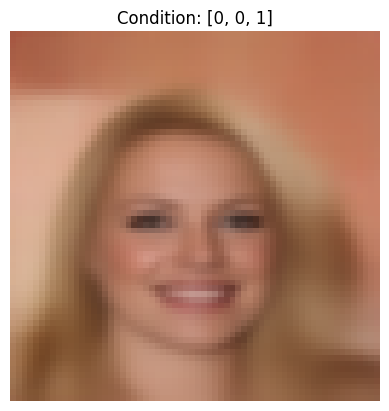

In [7]:
generate_face(model,[0,0,1])